<a href="https://colab.research.google.com/github/shubham1m/MusicGeneration/blob/main/MusicWithLSTM_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Training

In [ ]:
import os
import pickle
import numpy

from music21 import note, chord

from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import plot_model

!cp /content/drive/MyDrive/ColabNotebooks/models/RNNAttention.py .
from RNNAttention import get_distinct, create_lookups, prepare_sequences, get_music_list, create_network

##Set params

In [ ]:
# run params
section = '/content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data'
music_name = 'classical'

run_folder = '{}/'.format(section)
#run_folder += '_'.join([run_id, music_name])


store_folder = os.path.join(run_folder, 'store')
data_folder = os.path.join(section, music_name)

if not os.path.exists(os.path.join(run_folder, 'store')):
    os.mkdir(os.path.join(run_folder, 'store'))
    os.mkdir(os.path.join(run_folder, 'output'))
    os.mkdir(os.path.join(run_folder, 'weights'))
    os.mkdir(os.path.join(run_folder, 'viz'))
    


mode = 'build' # 'load' # 

# data params
intervals = range(1)
seq_len = 32

# model params
embed_size = 100
rnn_units = 256
use_attention = True

In [ ]:
print(data_folder)
print(store_folder)

/content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/classical
/content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/store


##Extract Notes

In [ ]:
if mode == 'build':
    
    music_list, parser = get_music_list(data_folder)
    print(len(music_list), 'files in total')

    notes = []
    durations = []

    for i, file in enumerate(music_list):
        print(i+1, "Parsing %s" % file)
        original_score = parser.parse(file).chordify()
        

        for interval in intervals:

            score = original_score.transpose(interval)

            notes.extend(['START'] * seq_len)
            durations.extend([0]* seq_len)

            for element in score.flat:
                
                if isinstance(element, note.Note):
                    if element.isRest:
                        notes.append(str(element.name))
                        durations.append(element.duration.quarterLength)
                    else:
                        notes.append(str(element.nameWithOctave))
                        durations.append(element.duration.quarterLength)

                if isinstance(element, chord.Chord):
                    notes.append('.'.join(n.nameWithOctave for n in element.pitches))
                    durations.append(element.duration.quarterLength)

    with open(os.path.join(store_folder, 'notes'), 'wb') as f:
        pickle.dump(notes, f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'wb') as f:
        pickle.dump(durations, f) 
else:
    with open(os.path.join(store_folder, 'notes'), 'rb') as f:
        notes = pickle.load(f) #['G2', 'D3', 'B3', 'A3', 'B3', 'D3', 'B3', 'D3', 'G2',...]
    with open(os.path.join(store_folder, 'durations'), 'rb') as f:
        durations = pickle.load(f)

36 files in total
1 Parsing /content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/classical/cs4-5bou.mid
2 Parsing /content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/classical/cs4-4sar.mid
3 Parsing /content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/classical/cs4-3cou.mid
4 Parsing /content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/classical/cs4-1pre.mid
5 Parsing /content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/classical/cs3-4sar.mid
6 Parsing /content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/classical/cs3-5bou.mid
7 Parsing /content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/classical/cs4-2all.mid
8 Parsing /content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/classical/cs3-6gig.mid
9 Parsing /content/drive/MyDrive/ColabNotebooks/MusicGeneration/MusicWithLSTM_Data/classical/cs3-3cou.mid
10 Parsing /content/drive/My

##Lookup table

In [ ]:
# get the distinct sets of notes and durations
note_names, n_notes = get_distinct(notes)
duration_names, n_durations = get_distinct(durations)
distincts = [note_names, n_notes, duration_names, n_durations]

with open(os.path.join(store_folder, 'distincts'), 'wb') as f:
    pickle.dump(distincts, f)

# make the lookup dictionaries for notes and dictionaries and save
note_to_int, int_to_note = create_lookups(note_names)
duration_to_int, int_to_duration = create_lookups(duration_names)
lookups = [note_to_int, int_to_note, duration_to_int, int_to_duration]

with open(os.path.join(store_folder, 'lookups'), 'wb') as f:
    pickle.dump(lookups, f)

In [ ]:
print('\nnote_to_int')
note_to_int


note_to_int


{'A2': 0,
 'A2.A3': 1,
 'A2.B2': 2,
 'A2.C3': 3,
 'A2.C3.D3.E3': 4,
 'A2.D3': 5,
 'A2.E-3': 6,
 'A2.E3': 7,
 'A2.E3.A3': 8,
 'A2.E3.C#4': 9,
 'A2.E3.C#4.A4': 10,
 'A2.E3.C#4.E4': 11,
 'A2.E3.C#4.G#4': 12,
 'A2.E3.C4': 13,
 'A2.E3.D4': 14,
 'A2.F#3': 15,
 'A2.F#3.C4': 16,
 'A2.F#3.D4': 17,
 'A2.F#3.D4.A4': 18,
 'A2.F#3.D4.E4': 19,
 'A2.F#3.D4.F#4': 20,
 'A2.F#4': 21,
 'A2.F3': 22,
 'A2.F3.C4': 23,
 'A2.F3.D4': 24,
 'A2.F3.D4.A4': 25,
 'A2.G3': 26,
 'A2.G3.C#4': 27,
 'A2.G3.D4': 28,
 'A3': 29,
 'A3.B-3': 30,
 'A3.B3': 31,
 'A3.B3.A4': 32,
 'A3.B3.C#4': 33,
 'A3.B3.C4': 34,
 'A3.B3.F#4.G4': 35,
 'A3.B3.G4': 36,
 'A3.C#4': 37,
 'A3.C#4.E4': 38,
 'A3.C4': 39,
 'A3.D4': 40,
 'A3.D4.E4': 41,
 'A3.D4.F#4': 42,
 'A3.E4': 43,
 'A3.E4.F#4': 44,
 'A3.E4.F#4.G4': 45,
 'A3.E4.G4': 46,
 'A3.F#4': 47,
 'A3.F#4.G4': 48,
 'A3.F4': 49,
 'A3.G#4.A4': 50,
 'A3.G4': 51,
 'A4': 52,
 'A4.B4': 53,
 'B-2': 54,
 'B-2.A3': 55,
 'B-2.B-3': 56,
 'B-2.D3': 57,
 'B-2.D3.A3': 58,
 'B-2.D3.E-3.G#3': 59,
 'B-2.D3.G#3': 

In [ ]:
print('\nduration_to_int')
duration_to_int


duration_to_int


{0: 0,
 Fraction(1, 12): 1,
 Fraction(1, 6): 2,
 0.25: 3,
 Fraction(1, 3): 4,
 Fraction(5, 12): 5,
 0.5: 6,
 Fraction(2, 3): 7,
 0.75: 8,
 1.0: 9,
 1.25: 10,
 Fraction(4, 3): 11,
 1.5: 12,
 1.75: 13,
 2.0: 14,
 2.25: 15,
 2.5: 16,
 3.0: 17,
 4.0: 18}

##Prepare data for NN

In [ ]:
network_input, network_output = prepare_sequences(notes, durations, lookups, distincts, seq_len)

In [ ]:
print('pitch input')
print(network_input[0][0])
print('duration input')
print(network_input[1][0])
print('pitch output')
print(network_output[0][0])
print('duration output')
print(network_output[1][0])

pitch input
[460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460 460
 460 460 460 460 460 460 460 460 460 460 460 460 460 460]
duration input
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
pitch output
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

##Create NN

In [ ]:
model, att_model = create_network(n_notes, n_durations, embed_size, rnn_units, use_attention)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 100)    46100       input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 100)    1900        input_2[0][0]                    
______________________________________________________________________________________________

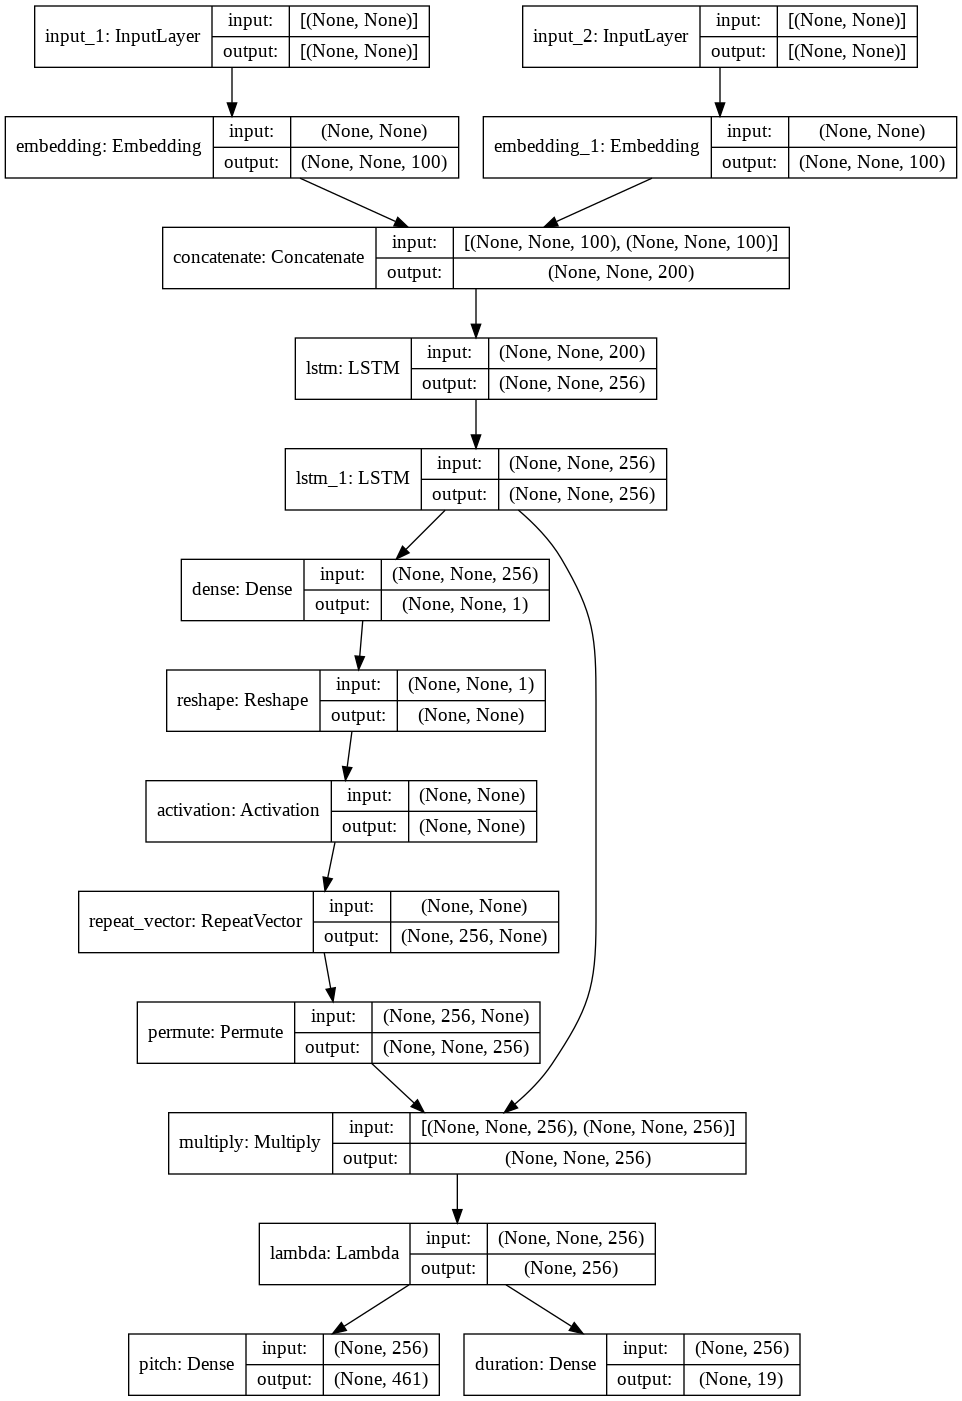

In [ ]:
plot_model(model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)

##Train NN

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')
# model.load_weights(os.path.join(weights_folder, "weights.h5"))

In [ ]:
weights_folder = os.path.join(run_folder, 'weights')

checkpoint1 = ModelCheckpoint(
    os.path.join(weights_folder, "weights-improvement-{epoch:02d}-{loss:.4f}-bigger.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

checkpoint2 = ModelCheckpoint(
    os.path.join(weights_folder, "weights.h5"),
    monitor='loss',
    verbose=0,
    save_best_only=True,
    mode='min'
)

early_stopping = EarlyStopping(
    monitor='loss'
    , restore_best_weights=True
    , patience = 10
)


callbacks_list = [
    checkpoint1
    , checkpoint2
    , early_stopping
 ]

model.save_weights(os.path.join(weights_folder, "weights.h5"))
model.fit(network_input, network_output
          , epochs=2000000, batch_size=32
          , validation_split = 0.2
          , callbacks=callbacks_list
          , shuffle=True
         )

Epoch 1/2000000
720/720 [==============================] - 233s 318ms/step - loss: 4.6911 - pitch_loss: 3.6645 - duration_loss: 1.0266 - val_loss: 4.7313 - val_pitch_loss: 3.9839 - val_duration_loss: 0.7474
Epoch 2/2000000
720/720 [==============================] - 227s 315ms/step - loss: 3.8093 - pitch_loss: 3.1563 - duration_loss: 0.6530 - val_loss: 4.8536 - val_pitch_loss: 4.1735 - val_duration_loss: 0.6801
Epoch 3/2000000
720/720 [==============================] - 228s 317ms/step - loss: 3.5948 - pitch_loss: 3.0220 - duration_loss: 0.5728 - val_loss: 4.6707 - val_pitch_loss: 4.0155 - val_duration_loss: 0.6552
Epoch 4/2000000
720/720 [==============================] - 230s 319ms/step - loss: 3.3754 - pitch_loss: 2.8686 - duration_loss: 0.5068 - val_loss: 4.8253 - val_pitch_loss: 4.0267 - val_duration_loss: 0.7986
Epoch 5/2000000
720/720 [==============================] - 229s 317ms/step - loss: 3.2178 - pitch_loss: 2.7535 - duration_loss: 0.4643 - val_loss: 4.9007 - val_pitch_loss: 